# Training on a pooled Deep Neural Network with manual convolution using atlas
I wrote a simple Keras Model which pools 3D objects into 1D using GlobalAveragePooling. 
Then this 1D was pushed into a Dense layer of 1024, and then softmax output layer of 5.
Majority work here is cleaning and organizing data so that it fit into the model.

Note: A lot of times running this code led to memory exceeded errors just due to the size of these
datasets, so I would do data cleaning + Manual Convolution first, save the data, close the kernel, and then run the model training section. Also, I haven't checked test accuracy yet - just comparing using validation accuracy

### Data Cleaning
Putting all the data together, cleaning formats, removing NaN values - making sure it can be input into a model

In [1]:
import numpy as np

In [2]:
# Importing all data
data = [np.load('data/resized/fractals_' + str(i) + '.npy').item() for i in range(1, 202)]
len(data)

201

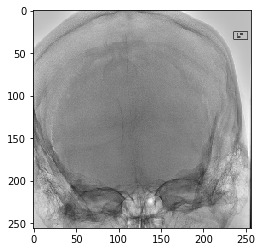

In [3]:
# Data Sanity Check
import matplotlib.pyplot as plt
plt.imshow(data[0]['X'][:, :, 0], cmap='gray')

In [4]:
# Creating a dataframe to house the data
import pandas as pd
df = pd.DataFrame(data)
df = df.drop(['__globals__', '__header__', '__version__'], axis=1)
df['y'] = 0 # New column in which I'll fill values

In [5]:
# This creates a new column 'y' that contains a TICI score if any of TICI_report, TICI_Dr1, or TICI_Dr2 are not null.
# This can then be used as our label in our image classification project.
def get_y(x):
    yr = x['TICI_report'][0]
    yd1 = x['TICI_Dr1'][0]
    yd2 = x['TICI_Dr2'][0]
    if (isinstance(yr, np.ndarray)):
        yr = yr[0]
    if (isinstance(yd1, np.ndarray)):
        yd1 = yd1[0]
    if(isinstance(yd2, np.ndarray)):
        yd2 = yd2[0]
    if (yr != 'nan'):
        return yr
    if(yd1 != 'nan'):
        return yd1
    elif(yd2 != 'nan'):
        return yd2
    return 'nan'

df['y'] = df.apply(lambda x: get_y(x), axis=1)

In [ ]:
# We don't need the 'TICI_Dr1', 'TICI_Dr2' or 'TICI_report' columns anymore
data = df[['X', 'y']]

In [ ]:
clean_data = data.dropna(how='any')
clean_data.loc[clean_data['y'] == '0 (bilateral MCA)', ['y']]= 0

# For this datapoint, I thought '2a?' might be another type of category, but
# I believe there is only one data point that has '2a?' as a category so I'm
# going to treat it as an error and convert it to '2a'
clean_data.loc[clean_data['y'] == '2a?', ['y']] = '2a'
len(clean_data)

/home/jupyter/.local/lib/python3.5/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


181

### Train-Test Split and to_categorical
Keeping a section of the data away from the model for final comparison, as well as converting categorical values into one-hot encoding for
the model to be able to comprehend.

In [ ]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.1
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(clean_data.drop('y', axis=1), clean_data['y'], test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False, stratify=None)

In [ ]:
# to_categorical (I used pd.get_dummies because they work with dataframes and return column name)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
# I made the entirety of y_test[1] = 0 as for this random_state y_test has no objects of TICI 1
y_test[1] = 0
# This is to order the columns 
cols = [0, 1, '2a', '2b', 3]
y_train = y_train[cols]
y_test = y_test[cols]
y_train.columns, y_test.columns

(Index([0, 1, '2a', '2b', 3], dtype='object'),
 Index([0, 1, '2a', '2b', 3], dtype='object'))

In [ ]:
# Converting Pandas DataFrames into numpy arrays, which keras supports
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
# Shape sanity check pt II
X_train[161][0].shape

(256, 256, 39)

In [ ]:
# Exceeds memory at this point
(X_train.shape, y_train.shape, X_test.shape,  y_test.shape)

((162, 1), (162, 5), (19, 1), (19, 5))

### Manual Convolution
Here I run our dataset through scipy's fftconvolve and use the atlas as the manual filter, as the first stage in the machine learning. (This is just me trying things just to see how they would turn out)

In [ ]:
atlas = np.load('data/atlas.npy')
atlas.shape

(256, 256, 39)

In [ ]:
import sys # This is because I'm extra and I wanted to see if I could actually do a progress bar
from scipy.signal import fftconvolve

X_train_in = np.zeros((162, 256, 256, 39))
for i in range(0, X_train_in.shape[0]):
    sys.stdout.write('\r')
    sys.stdout.write('[' + np.ceil(i/2).astype(int)*'#' + np.ceil(((X_train_in.shape[0] - i)/2) - 1).astype(int)*'.' + ']' + str(i))
    sys.stdout.flush()
    X_train_in[i] = fftconvolve(X_train[i][0], atlas, mode='same')

[##############################################################...................]123

In [ ]:
plt.imshow(X_train_in[0][:, :, 0], cmap='gray')

In [ ]:
# Converting X_train into shape (162, 256, 256, 39) - otherwise it was an array of np.arrays
X_train.shape
X_train_new = np.zeros((162, 256, 256, 39))
for i in range(0, len(X_train)):
    print(i, end=' ')
    X_train_new[i] = X_train[i][0]

In [ ]:
np.save('data/manual_conv/X_train_in.npy', X_train_in)

In [ ]:
np.save('data/manual_conv/X_train.npy', X_train_new)

In [ ]:
np.save('data/manual_conv/X_test.npy', X_test)

In [ ]:
np.save('data/manual_conv/y_train.npy', y_train)

In [ ]:
np.save('data/manual_conv/y_test.npy', y_test)

### Model Definition
Trial of a basic 3D into pooled 1D DNN model - just to see what happens
(Note: close the kernel first then restart it, then run these steps separately NOT THE STEPS ABOVE, otherwise memory gets exceeded) 

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input, Dense, GlobalAveragePooling3D
from keras.models import Model

# shape: (None, spatial_dim1, spatial_dim2, spatial_dim3, channels)
input_img = Input(shape=(256, 256, 39, 1))

# Nothing, just your standard multi-layer perceptron (I based this off of Simi's code)
x = GlobalAveragePooling3D()(input_img)
x = Dense(1024, activation='relu', use_bias=True)(x)
output = Dense(5, activation='softmax', use_bias=True)(x)

model = Model(inputs=input_img, outputs=output)
rmsprop = keras.optimizers.RMSprop(lr=0.05)
model.compile(optimizer=rmsprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

### Model fitting and training

In [ ]:
# Load these values in separately, so that memory doesn't get exceeded
X_train_conv = np.load('data/manual_conv/X_train_in.npy')

In [ ]:
X_train = np.load('data/manual_conv/X_train.npy')

In [ ]:
y_train = np.load('data/manual_conv/y_train.npy')

#### Training with manual convolution

In [ ]:
model.fit(X_train_conv[:, :, :, :, np.newaxis], y_train, epochs=10, batch_size=50, verbose=1)

Validation accuracy for this basic model is around 30% - which isn't that great

#### Training without manual convolution

In [ ]:
model.fit(X_train[:, :, :, :, np.newaxis], y_train, epochs=10, batch_size=50, verbose=1)

Down with the atlas then - the simple model without any manual convolution does much better than the one with! 